# MODELING WITH ANTIMONY

# Preliminaries

In [8]:
!pip install -q tellurium

In [9]:
import numpy as np
import tellurium as te
import matplotlib.pyplot as plt

# Using Antimony and Tellurium

Antimony is a language for describing biochemical pathways.
Consider a sequential pathway: $S_1 \xrightarrow{k_1 S_1} S_2 \xrightarrow{k_2 S_2} S_3$, with $S_1 =10$, $k_1 =1, k_2=1$.

In [10]:
MODEL1 = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""

In [11]:
# Loading the simulation
rr = te.loada(MODEL1)

In [12]:
# Running the simulation and collecting the data directly
data = rr.simulate(0, 5, 100) # start time, end time, number of points

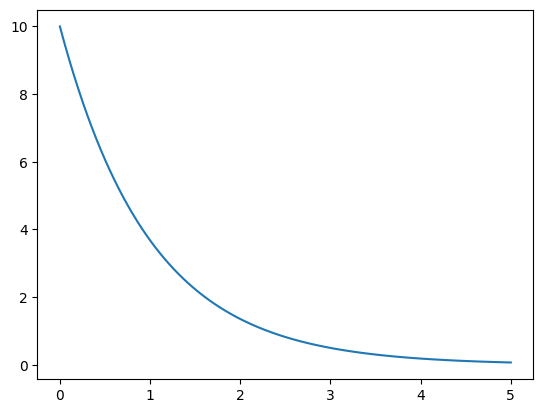

In [13]:
_ = plt.plot(data["time"], data["[S1]"])

In [14]:
print(rr.getAntimony())

// Created by libAntimony v2.15.0
// Compartments and Species:
species S1, S2, S3;

// Reactions:
_J0: S1 -> S2; k1*S1;
_J1: S2 -> S3; k2*S2;

// Species initializations:
S1 = 10;
S2 = 0;
S3 = 0;

// Variable initializations:
k1 = 1;
k2 = 2;

// Other declarations:
const k1, k2;



# Exploring kinetics in sequential pathway

$S_1 \xrightarrow{k_1 S_1} S_2 \xrightarrow{k_2 S_2} S_3$, with $S_1 =10$, $k_1 =1, k_2=1$.

In [15]:
MODEL2 = """
species S1, S2, S3

$S1 -> S2; k1*S1  # "$S1" means that S1 does not change its value
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""

In [16]:
# Function that adjust model parameters
def plotModel(model=MODEL2, parameter_dct=None,
              times=np.linspace(0, 5, 50), title="", is_plot=True):
    """
    Plots the simulation with the specified parameter values.

    Parameters
    ----------
    model: str
    parameter_dct: dict
        key: parameter name
        value: parameter value
    is_plot: bool

    Returns
    -------
    NamedArray
    """
    if parameter_dct is None:
        parameter_dct = {}
    rr = te.loada(model)
    for name, value in parameter_dct.items():
        rr[name] = value
    simulation_results = rr.simulate(times[0], times[-1], len(times))
    if is_plot:
        rr.plot(simulation_results, title=title)
    return simulation_results

# TESTS
results = plotModel(is_plot=False)
assert("NamedArray" in str(type(results)))
print("OK")

OK


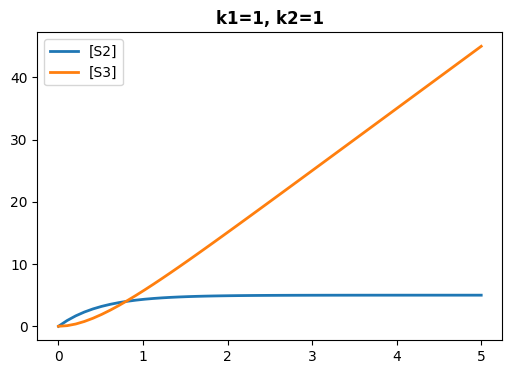

In [17]:
_ = plotModel(title="k1=1, k2=1")

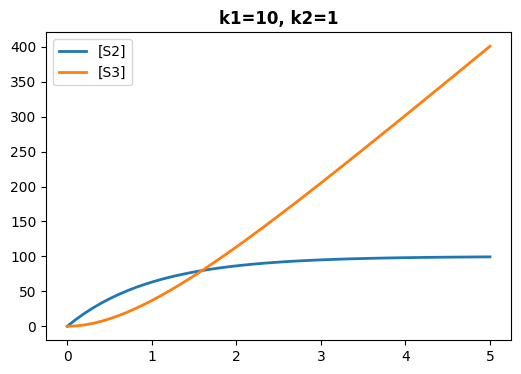

In [18]:
_ = plotModel(parameter_dct={"k1": 10, "k2": 1}, title="k1=10, k2=1")

# Exercise

1. Write a model with the following reactions for $k_1 = k_2 = k_3 = k_4 =1$.
    * $S_1 \xrightarrow{k_1} S_2$
    * $S_2 \xrightarrow{k_2} S_3$
    * $S_3 \xrightarrow{k_3} S_2$
    * $S_3 \xrightarrow{k_4} $

1. Plot the result.

1. What happens when we change $k_1$ to 0.1? 0.5? 1.5? 2.0?

# Accessing models in BioModels

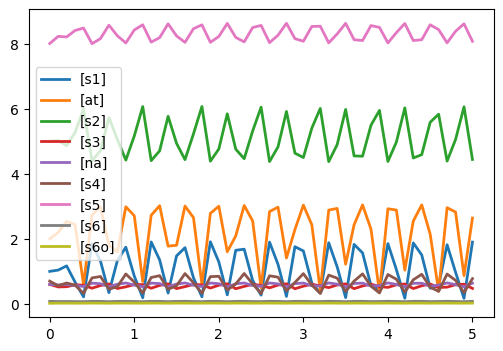

In [19]:
rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL3352181362/2/BIOMD0000000206_url.xml")
rr.simulate()
rr.plot()

In [20]:
print(rr.getAntimony())

// Created by libAntimony v2.15.0
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

# Event Statements

An event is an "external" action taken on the reaction network.

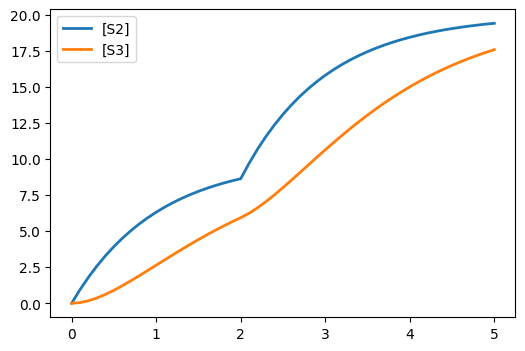

In [21]:
MODEL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

k1=1; k2=1; k3=1;
$S1 = 10; S2=0; S3=0
"""
rr = te.loada(EVENT_MODEL)
rr.simulate()
rr.plot()

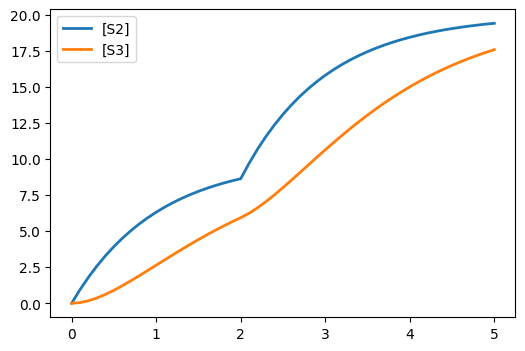

In [22]:
EVENT_MODEL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

k1=1; k2=1; k3=1;
$S1 = 10; S2=0; S3=0

at time >  2: S1=20
"""
rr = te.loada(EVENT_MODEL)
rr.simulate()
rr.plot()

# Implementing Proportional Control

Antimony has **assignment variables** that link species concentrations to variables. We can perform arithmetic on assignment variables. Below is an example of reporting the total concentration of ``S1`` and ``S2``.

In [23]:
MODEL1 = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2

total := S1 + S2
"""

## Simple model

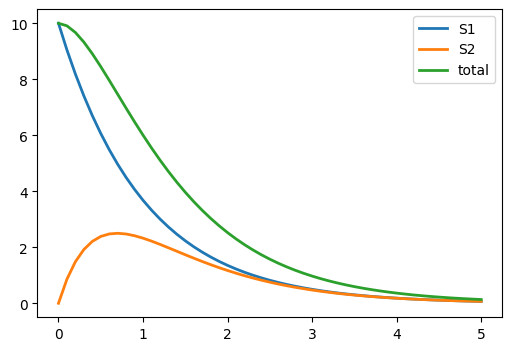

In [24]:
rr = te.loada(MODEL1)
rr.simulate(selections=["time", "S1", "S2", "total"])
rr.plot()

We can implement a proportional controller with ``setpoint` as the desired output for the system that has S1 as input and S3 as the output.
* ``e`` is the control error. ``e := setpoint - S3``
* We calculate ``S1`` from the controller. ``S1 := kP*e``

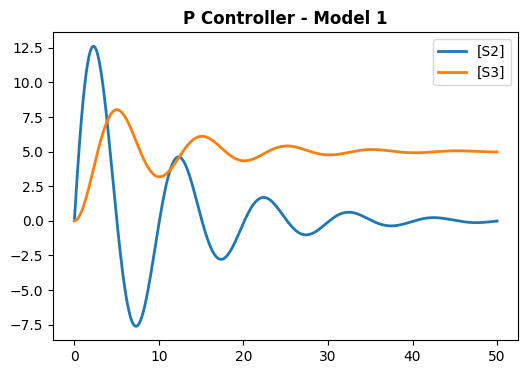

In [25]:
P_CONTROLLER = """
species S1, S2, S3

$S1 -> S2; k1*S1
S2 -> S3; k2*S2

S2 = 0
S3 = 0
k1 = 1
k2 = 0.2
setpoint = 0. # Dummy value
kP = 0. # Dummy value

e := setpoint - S3
$S1 := kP*e
"""
_ = plotModel(model=P_CONTROLLER, times=np.linspace(0, 50, 500),
              parameter_dct=dict(setpoint=5, kP=2), title="P Controller - Model 1")

## Plotting Control Results

Elements of the plot
* x-axis is time
* y-axis for system input and output
* setpoint plotted with output

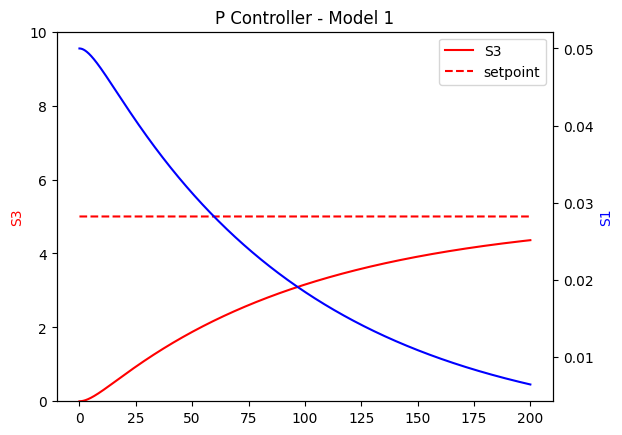

In [26]:
def plotClosedLoop(antimony_closed_loop_model, setpoint, input_name, output_name,
                    parameter_dct=None, ylim=None,
                    times=np.linspace(0, 5, 50), title="", is_plot=True):
    """
    Plots the simulation with the specified parameter values. Assumes that the
    model has a parameter "setpoint".

    Args:
        antimony_closed_loop_model: str
        setpoint: float
        input_name: str
        output_name: str
        parameter_dct: dict
            key: parameter name
            value: parameter value
        times: np-array
        title: str
        is_plot: bool

    Returns:
        NamedArray (times, input_array, output_array)
    """
    if parameter_dct is None:
        parameter_dct = {}
    rr = te.loada(antimony_closed_loop_model)
    for name, value in parameter_dct.items():
        rr[name] = value
    rr["setpoint"] = setpoint
    adj_input_name = "[%s]" % input_name
    adj_output_name = "[%s]" % output_name
    data_arr = rr.simulate(times[0], times[-1], len(times),
                           selections=["time", adj_input_name, adj_output_name])
    # Construct the plot if required
    if is_plot:
        xvals = data_arr["time"]
        plt.plot(xvals, data_arr[adj_output_name], color="red")
        plt.plot(xvals, np.repeat(setpoint, len(xvals)), color="red",
                 linestyle="--")
        ax = plt.gca()  # Get the current axis
        ax.set_ylabel(output_name, color="red")
        ax.set_title(title)
        plt.legend([output_name, "setpoint"])
        ax2 = ax.twinx()  # Make the second y axis
        ax2.plot(xvals, data_arr[adj_input_name], color="blue")
        ax2.set_ylabel(input_name, color="blue")
        if ylim is not None:
            ax.set_ylim([ylim[0], ylim[1]])
    return data_arr

# TESTS
_ = plotClosedLoop(P_CONTROLLER, 5, "S1", "S3", times=np.linspace(0, 200, 2000),
                    parameter_dct=dict(kP=0.01), ylim=[0, 10],
                    title="P Controller - Model 1", is_plot=True)

## Controlling a more complex model

A more involved model.

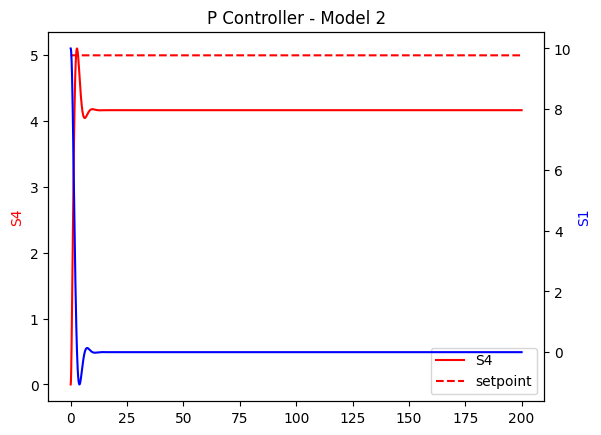

In [27]:
P_CONTROLLER2 = """
species S1, S2, S3

$S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S2; k3*S3
S2 -> S4; k4*S2
S4 ->S3; k5*S4

S1 = 0. # Dummy value
S2 = 0
S3 = 0
k1 = 1
k2 = 0.2
k3 = 1
k4 = 1
k5 = 1
setpoint = 5
kP = 0. # Dummy value

e := setpoint - S3
$S1 := kP*e
"""
_ = plotClosedLoop(P_CONTROLLER2, 5, "S1", "S4", times=np.linspace(0, 200, 2000),
                    parameter_dct=dict(kP=2),
                    title="P Controller - Model 2")

# Incorporating control into a BioModels model

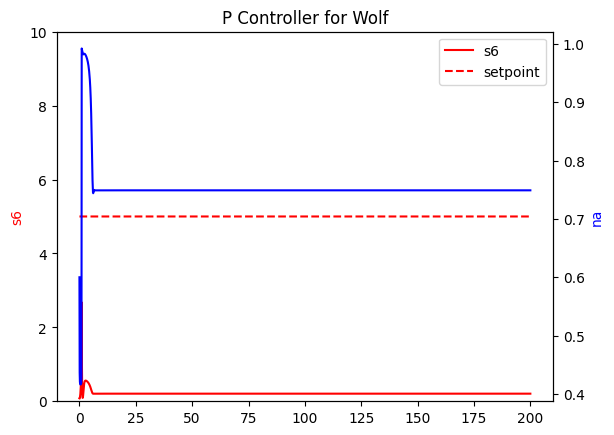

In [28]:
P_CONTROLLER_WOLF = """
// Created by libAntimony v2.14.0
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
  s2 = 5;
  s3 = 0.6;
  na = 0.6;
  s4 = 0.7;
  s5 = 8;
  s6 = 0.08;
  s6o = 0.02;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  k0 = 50;
  k0 has mM_min_1;
  k1 = 550;
  k1 has mM_1_min_1;
  k2 = 9.8;
  k2 has min_1;
  k31 = 323.8;
  k31 has mM_1_min_1;
  k33 = 57823.1;
  k33 has mM_1_min_1;
  k32 = 76411.1;
  k32 has mM_1_min_1;
  k34 = 23.7;
  k34 has mM_1_min_1;
  k4 = 80;
  k4 has mM_1_min_1;
  k5 = 9.7;
  k5 has min_1;
  k6 = 2000;
  k6 has mM_1_min_1;
  k7 = 28;
  k7 has min_1;
  k8 = 85.7;
  k8 has mM_1_min_1;
  k9 = 80;
  k9 has min_1;
  k10 = 375;
  k10 has min_1;
  atot = 4;
  atot has mM;
  ntot = 1;
  ntot has mM;
  n = 4;
  n has dimensionless;
  ki = 1;
  ki has mM;

  // Other declarations:
  const compartment_, k0, k1, k2, k31, k33, k32, k34, k4, k5, k6, k7, k8;
  const k9, k10, atot, ntot, n, ki;

  // Unit definitions:
  unit substance = 1e-3 mole;
  unit time_unit = 60 second;
  unit mM = 1e-3 mole / litre;
  unit mM_min_1 = 1e-3 mole / (litre * 60 second);
  unit min_1 = 1 / 60 second;
  unit mM_1_min_1 = litre / (1e-3 mole * 60 second);

  // Display Names:
  substance is "milli mole";
  time_unit is "min";
  compartment_ is "compartment";
  s1 is "Glucose";
  at_ is "ATP";
  s2 is "F16P";
  s3 is "Triose_Gly3Phos_DHAP";
  na is "NAD";
  s4 is "3PG";
  s5 is "Pyruvate";
  s6 is "Acetaldehyde";
  s6o is "extracellular acetaldehyde";

  // CV terms:
  s1 identity "http://identifiers.org/obo.chebi/CHEBI:17234",
              "http://identifiers.org/kegg.compound/C00293"
  at_ identity "http://identifiers.org/obo.chebi/CHEBI:15422",
               "http://identifiers.org/kegg.compound/C00002"
  s2 identity "http://identifiers.org/obo.chebi/CHEBI:16905",
              "http://identifiers.org/kegg.compound/C05378"
  s3 part "http://identifiers.org/obo.chebi/CHEBI:16108",
          "http://identifiers.org/obo.chebi/CHEBI:29052",
          "http://identifiers.org/kegg.compound/C00111",
          "http://identifiers.org/kegg.compound/C00118"
  na identity "http://identifiers.org/obo.chebi/CHEBI:15846",
              "http://identifiers.org/kegg.compound/C00003"
  s4 identity "http://identifiers.org/obo.chebi/CHEBI:17794",
              "http://identifiers.org/kegg.compound/C00197"
  s5 identity "http://identifiers.org/kegg.compound/C00022",
              "http://identifiers.org/chebi/CHEBI:32816"
  s5 identity "http://identifiers.org/obo.chebi/CHEBI:15361"
  s6 identity "http://identifiers.org/obo.chebi/CHEBI:15343",
              "http://identifiers.org/kegg.compound/C00084"
  s6o identity "http://identifiers.org/obo.chebi/CHEBI:15343",
               "http://identifiers.org/kegg.compound/C00084"
  v1 part "http://identifiers.org/kegg.reaction/R00756",
          "http://identifiers.org/kegg.reaction/R00299"
  v1 part "http://identifiers.org/ec-code/2.7.1.11",
          "http://identifiers.org/ec-code/5.3.1.9"
  v2 identity "http://identifiers.org/ec-code/4.1.2.13",
              "http://identifiers.org/kegg.reaction/R01070"
  v3 part "http://identifiers.org/ec-code/2.7.2.3",
          "http://identifiers.org/ec-code/1.2.1.12"
  v4 part "http://identifiers.org/kegg.reaction/R00658",
          "http://identifiers.org/kegg.reaction/R00200"
  v4 part "http://identifiers.org/ec-code/2.7.1.40"
  v5 hypernym "http://identifiers.org/ec-code/4.1.1.1",
              "http://identifiers.org/kegg.reaction/R00224"
  v7 hypernym "http://identifiers.org/obo.go/GO:0006754"
  v8 part "http://identifiers.org/kegg.reaction/R05679"
  v9 hypernym "http://identifiers.org/obo.go/GO:0046187"
  v6 hypernym "http://identifiers.org/ec-code/1.1.1.71",
              "http://identifiers.org/kegg.reaction/R00754"
  v0 hypernym "http://identifiers.org/obo.go/GO:0046323"

  model model_entity_is "http://identifiers.org/biomodels.db/MODEL3352181362"
  model model_entity_is "http://identifiers.org/biomodels.db/BIOMD0000000206"
  model description "http://identifiers.org/pubmed/10692304"
  model taxon "http://identifiers.org/taxonomy/4932"
  model hypernym "http://identifiers.org/obo.go/GO:0006096"
  model identity "http://identifiers.org/kegg.pathway/sce00010"
  model created "2008-10-06T20:39:38Z"
  model modified "2012-07-05T14:48:43Z"
  model creator1.givenName "Harish"
  model creator1.familyName "Dharuri"
  model creator1.organization "California Institute of Technology"
  model creator1.email "hdharuri@cds.caltech.edu"

  // Notes:
  model notes ```
   <p>Model reproduces the dynamics of ATP and NADH as depicted in Fig 4 of the paper.  Model successfully tested on Jarnac and MathSBML.</p>
    <br/>
    <p>To the extent possible under law, all copyright and related or neighbouring rights to this encoded model have been dedicated to the public domain worldwide. Please refer to      <a href="http://creativecommons.org/publicdomain/zero/1.0/" title="Creative Commons CC0">CC0 Public Domain Dedication</a>
          for more information.      </p>
    <p>In summary, you are entitled to use this encoded model in absolutely any manner you deem suitable, verbatim, or with modification, alone or embedded it in a larger context, redistribute it, commercially or not, in a restricted way or not.</p>
    <br/>
    <p>To cite BioModels Database, please use:      <a href="http://www.ncbi.nlm.nih.gov/pubmed/20587024" target="_blank">Li C, Donizelli M, Rodriguez N, Dharuri H, Endler L, Chelliah V, Li L, He E, Henry A, Stefan MI, Snoep JL, Hucka M, Le Novère N, Laibe C (2010) BioModels Database: An enhanced, curated and annotated resource for published quantitative kinetic models. BMC Syst Biol., 4:92.</a></p>
```
######VVVVVVV Added
setpoint = 0 # Dummy
kP = 0 # Dummy value

e := setpoint - s6
$s1 := kP*e
#^^^^^^^^^^^^^^^

end

Wolf2000_Glycolytic_Oscillations is "Wolf2000_Glycolytic_Oscillations"
"""

_ = plotClosedLoop(P_CONTROLLER_WOLF, 5, "na", "s6", times=np.linspace(0, 200, 2000),
                    parameter_dct=dict(kP=2),
                    title="P Controller for Wolf", ylim=[0, 10], is_plot=True)

# Implementing Proportional Integral Control

Antimony rate laws allow for computing integrals. Writing ``ei = r'`` calculates the integral of ``r``.

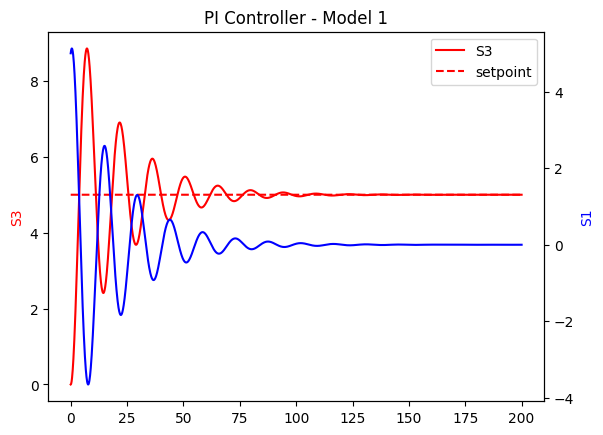

In [29]:
PI_CONTROLLER = """
species S1, S2, S3

$S1 -> S2; k1*S1
S2 -> S3; k2*S2

S2 = 0
S3 = 0
k1 = 1
k2 = 0.2
setpoint = 0. # Dummy value
kP = 0. # Dummy value
kI = 0. # Dummy value

e := setpoint - S3
ei = 0
ei' = e
$S1 := kP*e + kI*ei
"""
_ = plotClosedLoop(PI_CONTROLLER, 5, "S1", "S3", times=np.linspace(0, 200, 2000),
                    parameter_dct=dict(kP=1, kI=0.1),
                    title="PI Controller - Model 1", is_plot=True)

# Exercise
Do PI control for Wolf model.